In [1]:
%matplotlib widget
import psycopg2
import numpy as np
import gower
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm.notebook import tqdm

from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

# Loading data

## Querying database

In [2]:
# Loading data
conn = psycopg2.connect(database="full_STUPS",
                        user="postgres",
                        host='localhost',
                        password="postgres",
                        port=5432)
cur = conn.cursor()
cur.execute( '''select distinct ep.*, id_lot
                from echantillon_propriete ep 
                inner join echantillon e on e.id = ep.id 
                inner join composition c on c.id = e.id_composition 
                inner join lot_complet lc on (lc.e1 = c.id or lc.e2 = c.id)
                order by id_lot''')
samples = cur.fetchall()
conn.commit()
conn.close()
colnames = [desc[0] for desc in cur.description]

## Preparing dataset

In [3]:
X = pd.DataFrame(list(samples), columns=colnames) 
y = X['id_lot']

X = X.drop(columns=['id', 'num_echantillon', 'id_lot'])

# Subsampling data
subsample = False

if subsample:
    X = X.iloc[:3750, :]
    
print(f'Samples shape : {X.shape}')

Samples shape : (1861, 52)


# Computing Gower distance

In [4]:
# Computing distance matrix between all samples
dist_matrix = gower.gower_matrix(X)
print(f'Distance matrix size : {dist_matrix.size}')

Distance matrix size : 3463321


# Computing t-SNE

In [5]:
# Computing t-SNE
tsne = TSNE(n_components=3,
            perplexity=50,
            init='random',
            metric='precomputed')
embedding = tsne.fit_transform(dist_matrix)

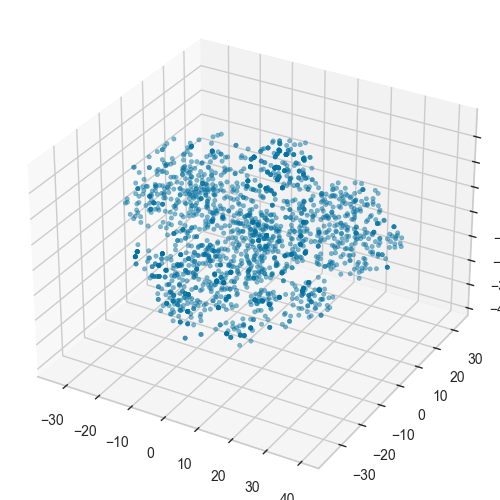

In [6]:
# Printing t-SNE results
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# plot
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=10, marker='o',  alpha=0.5)

# Looking for the optimal number of clusters

## Computing silhouette score *k* different number of clusters

In [7]:
# Computing different clustering silhouette score
# using kmenoids with different number of clusters 
labels_results = []
wcss = []
min_clusters = 2
nb_clusters = 100
nb_clusters_range = range(min_clusters, nb_clusters + min_clusters)

for i in tqdm(nb_clusters_range):
    model = KMedoids(n_clusters=i, init='k-medoids++').fit(embedding)
    cluster_labels = model.labels_
    silhouette_avg = silhouette_score(embedding, cluster_labels)
    labels_results.append(cluster_labels)
    wcss.append(silhouette_avg)

  0%|          | 0/100 [00:00<?, ?it/s]

## Silhouette score curve

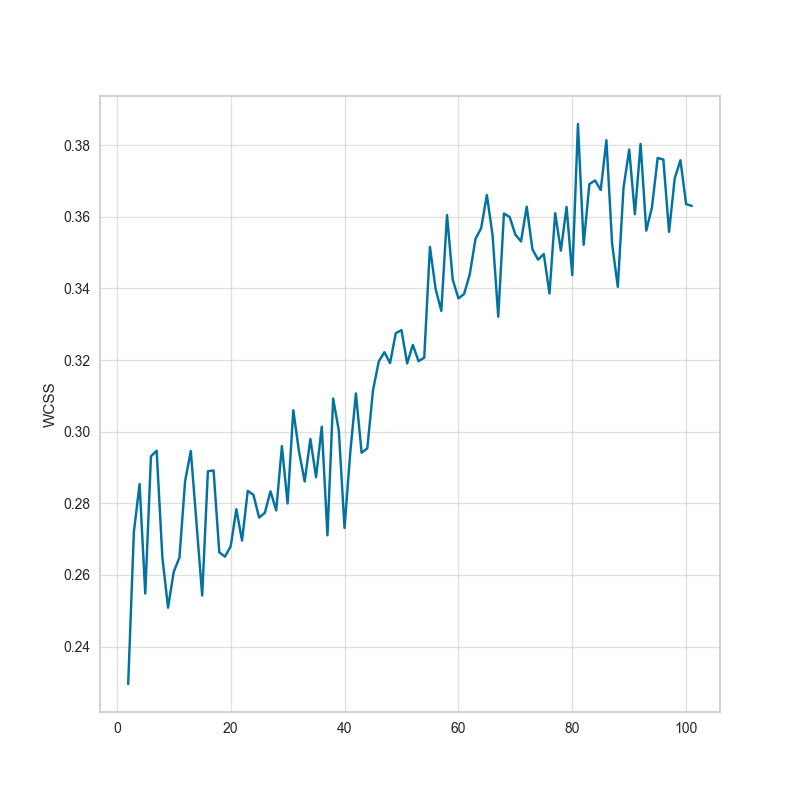

In [8]:
# Printing silhouette curve(s)
x = nb_clusters_range

fig = plt.figure(figsize=(8, 8))
plt.plot(x, wcss)
#plt.plot(x, d_wcss)
#plt.plot(x, d2_wcss)
plt.ylabel('WCSS')

plt.grid(visible=True, alpha=0.6)
plt.show()

# Selecting optimal number of clusters

In [9]:
# Finding the optimal cluster number
index_cluster = np.argmax(wcss)
optimal_hyperparameter_number = index_cluster + 1 # Indexes start at 0.
print(f'Optimal number of clusters : {optimal_hyperparameter_number}.')

Optimal number of clusters : 80.


# Printing cluster

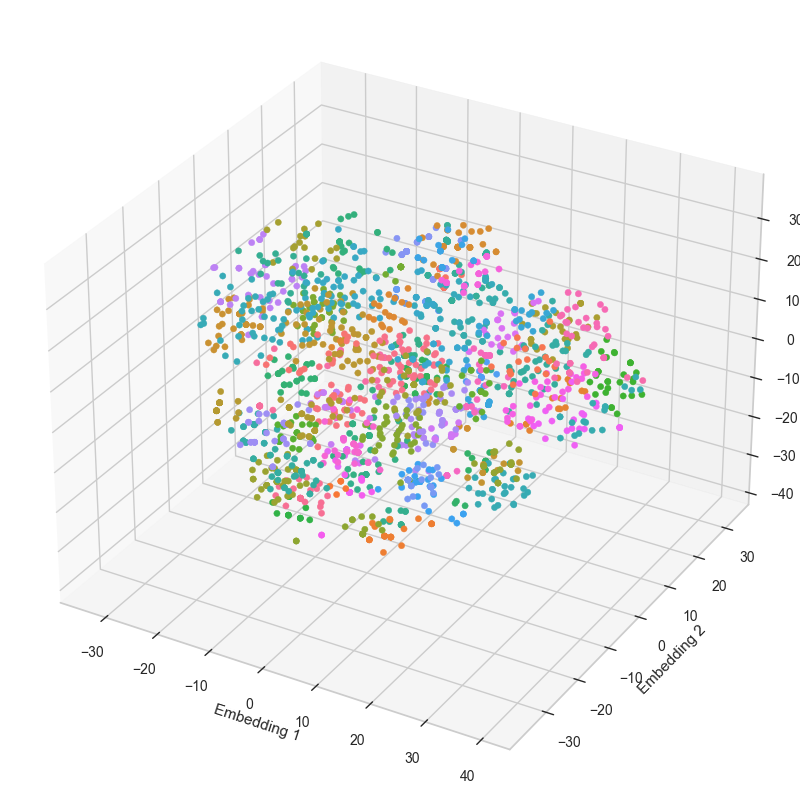

In [10]:
# Printing the cluster according to the optimal cluster number
cluster_labels = labels_results[optimal_hyperparameter_number]
embedding_df = pd.DataFrame({'x': embedding[:, 0],
                             'y': embedding[:, 1],
                             'z': embedding[:, 2],
                             'label': cluster_labels})

# axes instance
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=False)

ax.set_xlabel('Embedding 1')
ax.set_ylabel('Embedding 2')
ax.set_zlabel('Embedding 3')
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", len(np.unique(cluster_labels))).as_hex())

# plot
sc = ax.scatter(embedding_df.loc[:, 'x'], embedding_df.loc[:, 'y'], embedding_df.loc[:, 'z'], s=20, c=embedding_df.loc[:, 'label'], marker='o', cmap=cmap, alpha=1)

# Evaluating results

TODO (?)